# Stock predict practice

参考　https://supersoftware.jp/tech/20220907/17599/

- LSTM(Long short time memory)を用いて株価の予測を行う。始値、終値、高値、安値を予測することで5日間のローソク足を予測する

- LSTMの特徴として、RNNの仕組みに加えて長期的記憶をアウトプットし、それを少しずつ変えてインプットデータとして使用することで長・短期記憶を実現し、飛躍的な成果を挙げました。データの長期の特徴、短期の特徴を記憶して、さらには一部を忘れることも可能なので、より人間の脳に近いと言えるかもしれません。２０１６年頃からGoogle、Apple、Amazon各社の音声認識などにもLSTMが使われている実用度も知名度も高い手法です。

実装について
- ここで実装する基本的な考え方として、株価の時系列データをwindow（窓）と呼ばれる期間分ずらしたデータをインプットデータとしてデータをインプットデータとして学習する。例えばWindowサイズが60の場合、過去60日分(3ヶ月)の株価データを学習して61~65日目（一週間）の株価を予想することを繰り返して学習する

### ライブラリのインポート


In [1]:
from selenium import webdriver
import time
from selenium.webdriver.common.by import By
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import random
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from datetime import datetime
from workalendar.asia import Japan
import mplfinance as mpf
import plotly.graph_objects as go

### データを取得 

- 株価データを YAHOO!finance より取得する

In [2]:
'''
# Seleniumを使用することで、JavaScriptを実行
driver = webdriver.Chrome()

# 株価情報を取得するURLを指定します
# url = "https://finance.yahoo.com/quote/4482.T/history?p=4482.T"
url = "https://finance.yahoo.com/quote/4482.T/history?period1=1576627200&period2=1693267200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true"

# URLからHTMLを取得します
driver.get(url)
# ページをスクロールして全ての株価情報を読み込む
last_height = driver.execute_script("return document.body.scrollHeight")
while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(1)
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

# 株価表のテーブル要素を取得する
table = driver.find_element(By.XPATH, "//table[@class='W(100%) M(0)']")

with open("Wills_stock_prices.csv", "w", newline="") as f:
    writer = csv.writer(f)
    # ヘッダーを書き込む
    headers = [th.text for th in table.find_elements(By.XPATH, "//tr/th")]
    writer.writerow(headers)
    # 行を書き込む
    rows = table.find_elements(By.XPATH, "//tr[@class='BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)']")
    for row in rows:
        data = [td.text for td in row.find_elements(By.XPATH, ".//td")]
        writer.writerow(data)
    # 全てのI/O操作が完了した後にファイルを閉じる
    f.close()
'''


'\n# Seleniumを使用することで、JavaScriptを実行\ndriver = webdriver.Chrome()\n\n# 株価情報を取得するURLを指定します\n# url = "https://finance.yahoo.com/quote/4482.T/history?p=4482.T"\nurl = "https://finance.yahoo.com/quote/4482.T/history?period1=1576627200&period2=1693267200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true"\n\n# URLからHTMLを取得します\ndriver.get(url)\n# ページをスクロールして全ての株価情報を読み込む\nlast_height = driver.execute_script("return document.body.scrollHeight")\nwhile True:\n    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")\n    time.sleep(1)\n    new_height = driver.execute_script("return document.body.scrollHeight")\n    if new_height == last_height:\n        break\n    last_height = new_height\n\n# 株価表のテーブル要素を取得する\ntable = driver.find_element(By.XPATH, "//table[@class=\'W(100%) M(0)\']")\n\nwith open("Wills_stock_prices.csv", "w", newline="") as f:\n    writer = csv.writer(f)\n    # ヘッダーを書き込む\n    headers = [th.text for th in table.find_elements(By.XPATH, "//tr/th")]

In [3]:
'''
path = '/Users/k.mori/Desktop/python_study/stock_predict/Wills_stock_prices.csv'
df = pd.read_csv(path, encoding='utf_8')
df
'''

"\npath = '/Users/k.mori/Desktop/python_study/stock_predict/Wills_stock_prices.csv'\ndf = pd.read_csv(path, encoding='utf_8')\ndf\n"

In [4]:
'''
# カラム名の変更
rename_dict = {"Date": "日時",
               "Open": "始値",
               "High": "高値",
               "Low": "安値",
               "Close*": "終値",
               "Adj Close**": "調整後終値",
               "Volume": "出来高(株)",}
df = df.rename(columns=rename_dict)
df
'''

'\n# カラム名の変更\nrename_dict = {"Date": "日時",\n               "Open": "始値",\n               "High": "高値",\n               "Low": "安値",\n               "Close*": "終値",\n               "Adj Close**": "調整後終値",\n               "Volume": "出来高(株)",}\ndf = df.rename(columns=rename_dict)\ndf\n'

### データを取得　(手入力の場合)
- みんかぶ
　https://minkabu.jp/stock/4482/daily_bar

In [5]:
path = '/Users/k.mori/Desktop/python_study/stock_predict/stock_data.csv'
df = pd.read_csv(path, encoding='utf_8')
df.head()

,日時,始値,高値,安値,終値,調整後終値,出来高(株)
0,2023/9/5,610,611,605,608,608,"20,000"
1,2023/9/4,590,618,587,614,614,"62,700"
2,2023/9/1,584,585,581,584,584,"14,000"
3,2023/8/31,582,584,581,581,581,"5,900"
4,2023/8/30,585,589,580,580,580,"27,100"


### データの確認

In [6]:
# データの型
df.dtypes

日時        object
始値        object
高値        object
安値        object
終値        object
調整後終値     object
出来高(株)    object
dtype: object

In [7]:
# 「、」を削除
columns_convert  = ['始値','高値','安値','終値','調整後終値','出来高(株)']
df[columns_convert] = df[columns_convert].astype(str).replace(',', '',regex=True)

# データの型の変更
df = df.astype({'日時':'datetime64[ns]',
                '始値':'float64',
                '高値':'float64',
                '安値':'float64',
                '終値':'float64',
                '調整後終値':'float64',
                '出来高(株)':'int32'})
df.dtypes

日時        datetime64[ns]
始値               float64
高値               float64
安値               float64
終値               float64
調整後終値            float64
出来高(株)             int32
dtype: object

In [8]:
# 欠損値の確認
df.isnull().sum()

日時        0
始値        0
高値        0
安値        0
終値        0
調整後終値     0
出来高(株)    0
dtype: int64

In [9]:
df.describe()

,日時,始値,高値,安値,終値,調整後終値,出来高(株)
count,907,907.000000,907.000000,907.000000,907.000000,907.000000,9.070000e+02
mean,2021-10-30 17:38:57.816979200,1266.480706,1300.151047,1231.249173,1263.647189,868.494046,1.187848e+05
min,2019-12-18 00:00:00,542.000000,550.000000,535.000000,541.000000,541.000000,4.400000e+03
25%,2020-11-26 12:00:00,645.500000,654.500000,634.000000,644.500000,636.000000,3.330000e+04
50%,2021-10-29 00:00:00,852.000000,876.000000,823.000000,846.000000,804.000000,6.780000e+04
75%,2022-10-04 12:00:00,1212.500000,1249.000000,1171.500000,1210.500000,1054.350000,1.289500e+05
max,2023-09-05 00:00:00,5000.000000,5350.000000,4660.000000,4860.000000,1885.000000,1.693400e+06
std,NaN,1086.241019,1124.711093,1047.331218,1080.875668,272.199171,1.712325e+05


In [10]:
### データの日付が古い順に並べる(2019-12-18 ~ 2023-08-24)
df = df.sort_values(by='日時')
df.reset_index(inplace=True,drop=True)
df

,日時,始値,高値,安値,終値,調整後終値,出来高(株)
0,2019-12-18,4535.0,4960.0,4000.0,4050.0,1012.5,845000
1,2019-12-19,4750.0,4750.0,4660.0,4750.0,1187.5,308900
2,2019-12-20,5000.0,5350.0,4500.0,4860.0,1215.0,1693400
3,2019-12-23,4650.0,4745.0,4325.0,4530.0,1132.5,300800
4,2019-12-24,4460.0,5020.0,4290.0,4565.0,1141.2,752800
...,...,...,...,...,...,...,...
902,2023-08-30,585.0,589.0,580.0,580.0,580.0,27100
903,2023-08-31,582.0,584.0,581.0,581.0,581.0,5900
904,2023-09-01,584.0,585.0,581.0,584.0,584.0,14000
905,2023-09-04,590.0,618.0,587.0,614.0,614.0,62700


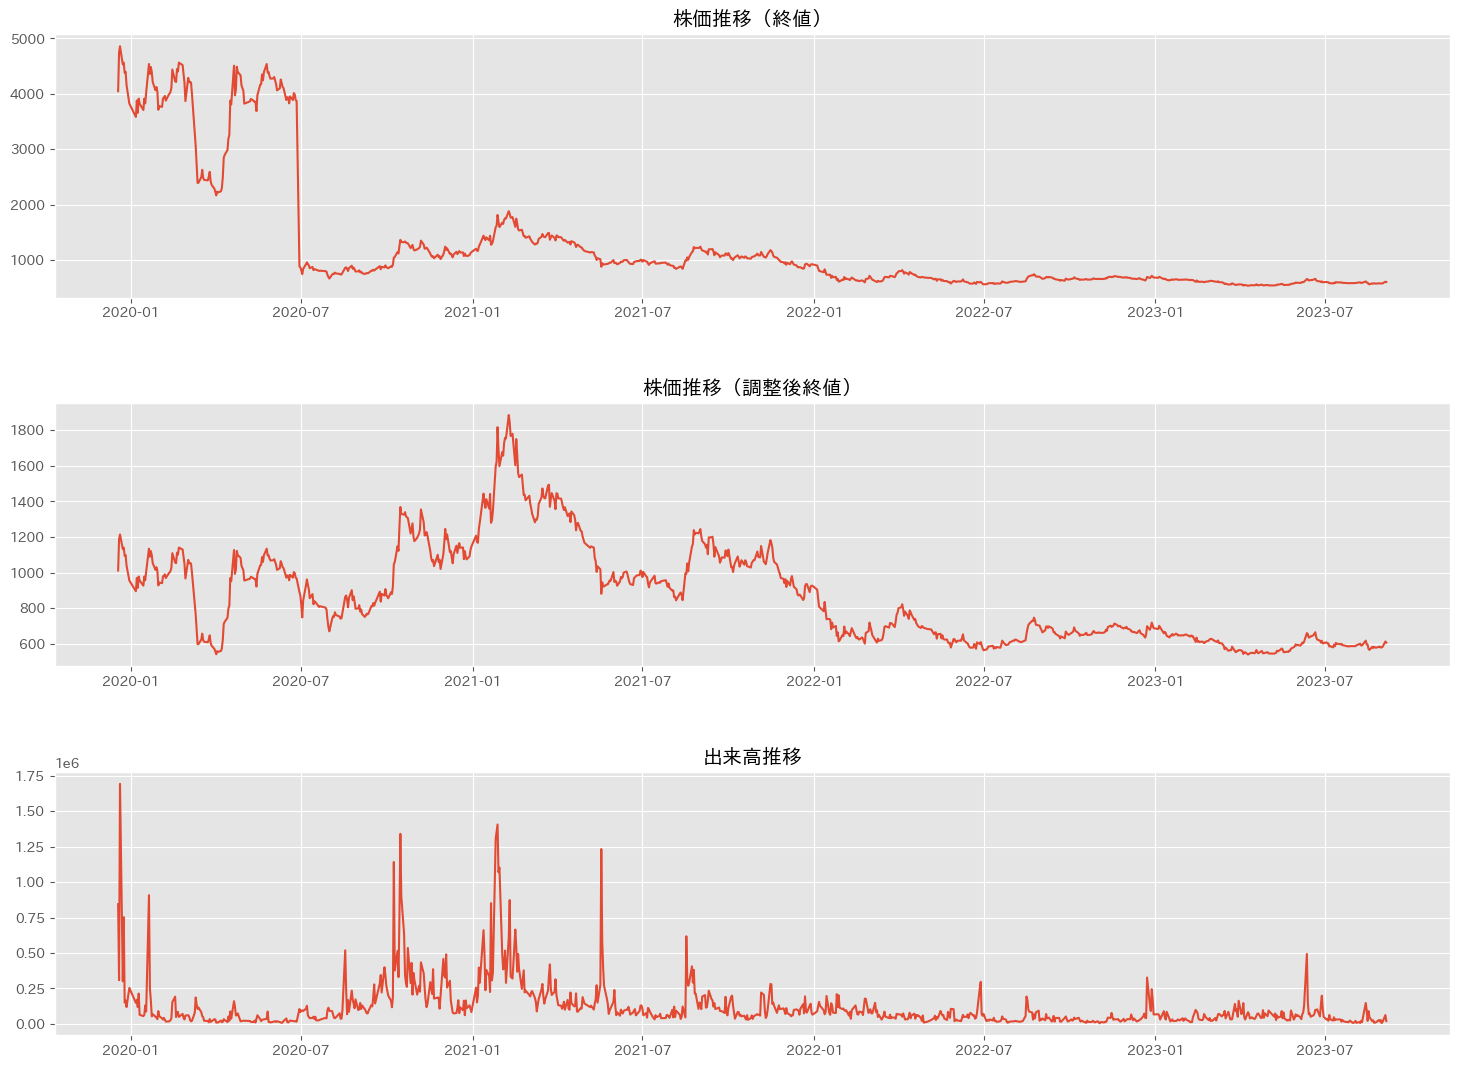

In [11]:
#株価データの終値をグラフで確認
fig, axes = plt.subplots(3,1,figsize=(18,13))
axes[0].plot(df['日時'],df['終値'])
axes[0].set_title('株価推移（終値）')

axes[1].plot(df['日時'],df['調整後終値'])
axes[1].set_title('株価推移（調整後終値）')


axes[2].plot(df['日時'],df['出来高(株)'])
axes[2].set_title('出来高推移')
fig.subplots_adjust(hspace=0.4)

In [12]:
start_dat = '2020-06-20'
end_day = '2020-07-05'
df[(start_dat < df['日時']) & (df['日時'] < end_day)]

,日時,始値,高値,安値,終値,調整後終値,出来高(株)
121,2020-06-22,3925.0,3980.0,3860.0,3890.0,972.5,20300
122,2020-06-23,3950.0,4035.0,3860.0,4015.0,1003.7,20400
123,2020-06-24,4015.0,4060.0,3985.0,3990.0,997.5,17700
124,2020-06-25,3920.0,3960.0,3860.0,3890.0,972.5,19200
125,2020-06-26,3890.0,3925.0,3860.0,3870.0,967.5,15800
126,2020-06-29,950.0,950.0,881.0,892.0,892.0,104800
127,2020-06-30,907.0,925.0,846.0,872.0,872.0,83600
128,2020-07-01,868.0,868.0,816.0,819.0,819.0,94600
129,2020-07-02,820.0,826.0,738.0,749.0,749.0,94600
130,2020-07-03,749.0,849.0,749.0,844.0,844.0,91300


In [13]:

def highlight_rows(x):
    if x.name in [125, 126]:
        return ['background-color: green']*len(x)
    else:
        return ['']*len(x)

styled_df = df.style.apply(highlight_rows, axis=1)

start_row = 121
end_row = 130
sliced_df = df.iloc[start_row:end_row, :]
styled_df = sliced_df.style.apply(highlight_rows, axis=1)
styled_df

,日時,始値,高値,安値,終値,調整後終値,出来高(株)
121,2020-06-22 00:00:00,3925.000000,3980.000000,3860.000000,3890.000000,972.500000,20300
122,2020-06-23 00:00:00,3950.000000,4035.000000,3860.000000,4015.000000,1003.700000,20400
123,2020-06-24 00:00:00,4015.000000,4060.000000,3985.000000,3990.000000,997.500000,17700
124,2020-06-25 00:00:00,3920.000000,3960.000000,3860.000000,3890.000000,972.500000,19200
125,2020-06-26 00:00:00,3890.000000,3925.000000,3860.000000,3870.000000,967.500000,15800
126,2020-06-29 00:00:00,950.000000,950.000000,881.000000,892.000000,892.000000,104800
127,2020-06-30 00:00:00,907.000000,925.000000,846.000000,872.000000,872.000000,83600
128,2020-07-01 00:00:00,868.000000,868.000000,816.000000,819.000000,819.000000,94600
129,2020-07-02 00:00:00,820.000000,826.000000,738.000000,749.000000,749.000000,94600


- 株価推移のグラフで2020-07で大きく株価が下がっている　>> 2020-06-29に株式分割が行われため株価が下がってように見えていた。これを考慮して調整された株価が調整後終値である。
- 出来高についても株式分割をされたことで調整する必要があると考える。今回1/4に株式が分割されたので2020-06-26より前の出来高を４倍する必要がある。

In [14]:
df['調整後出来高'] = df['出来高(株)'] 
df.loc[:125,'調整後出来高'] = df.loc[:125,'調整後出来高']*4
df[121:130]

,日時,始値,高値,安値,終値,調整後終値,出来高(株),調整後出来高
121,2020-06-22,3925.0,3980.0,3860.0,3890.0,972.5,20300,81200
122,2020-06-23,3950.0,4035.0,3860.0,4015.0,1003.7,20400,81600
123,2020-06-24,4015.0,4060.0,3985.0,3990.0,997.5,17700,70800
124,2020-06-25,3920.0,3960.0,3860.0,3890.0,972.5,19200,76800
125,2020-06-26,3890.0,3925.0,3860.0,3870.0,967.5,15800,63200
126,2020-06-29,950.0,950.0,881.0,892.0,892.0,104800,104800
127,2020-06-30,907.0,925.0,846.0,872.0,872.0,83600,83600
128,2020-07-01,868.0,868.0,816.0,819.0,819.0,94600,94600
129,2020-07-02,820.0,826.0,738.0,749.0,749.0,94600,94600


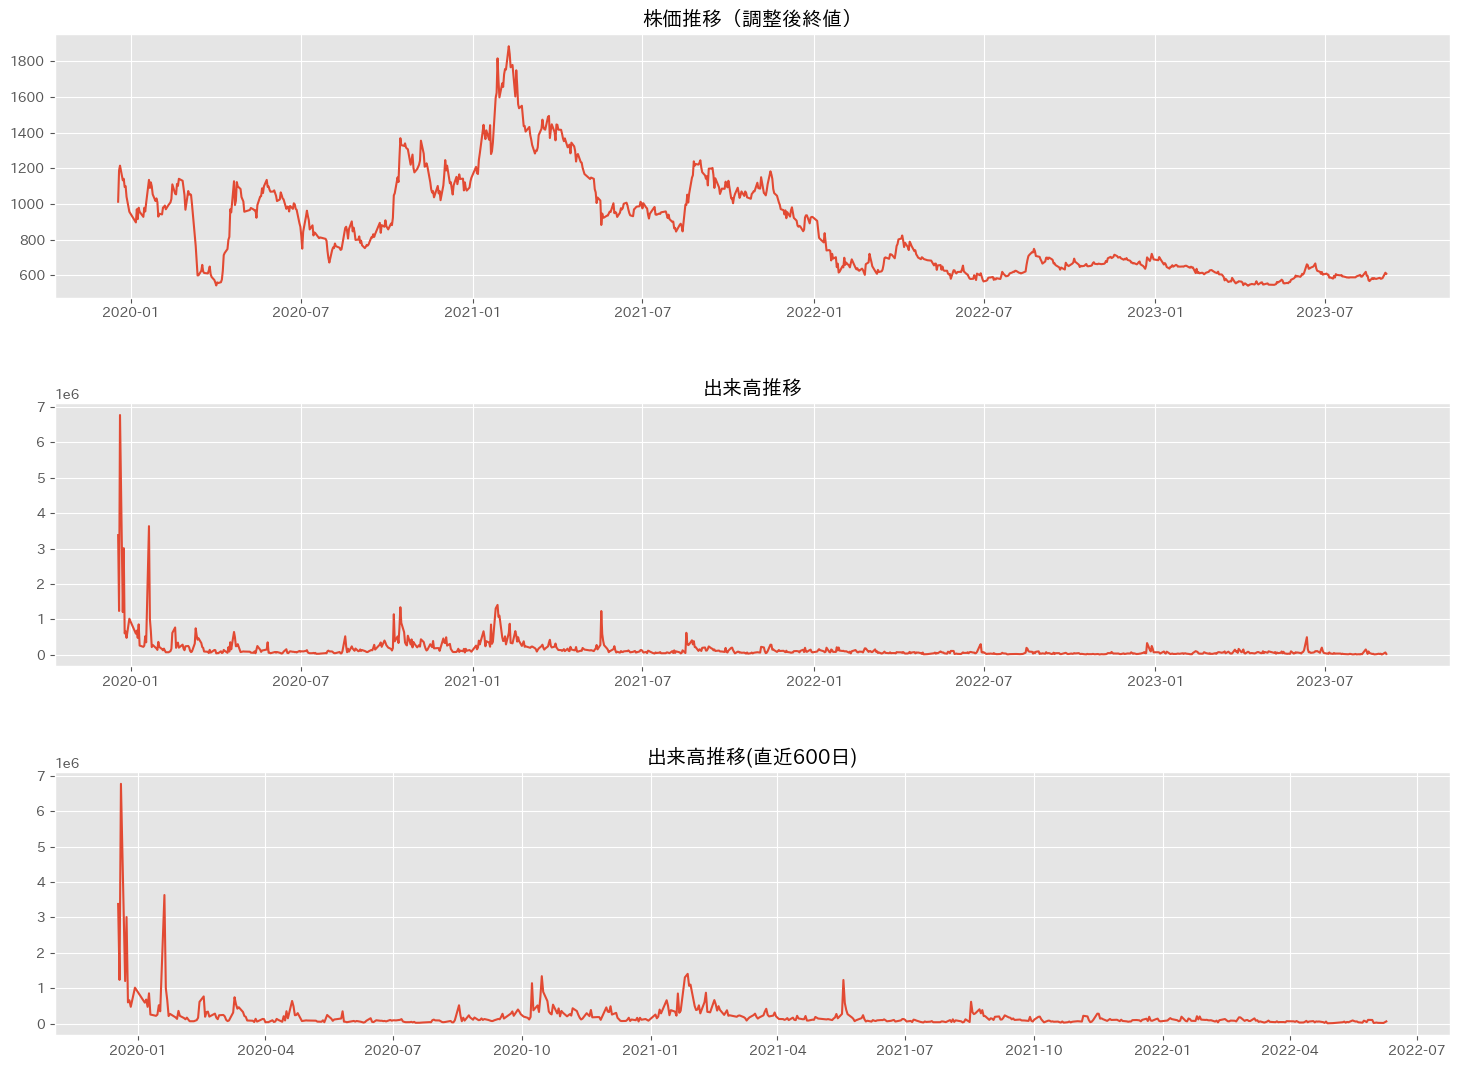

In [15]:
#調整後の株価データの終値をグラフで確認
fig, axes = plt.subplots(3,1,figsize=(18,13))

axes[0].plot(df['日時'],df['調整後終値'])
axes[0].set_title('株価推移（調整後終値）')

axes[1].plot(df['日時'],df['調整後出来高'])
axes[1].set_title('出来高推移')

axes[2].plot(df.loc[:600,'日時'],df.loc[:600,'調整後出来高'])
axes[2].set_title('出来高推移(直近600日)')
fig.subplots_adjust(hspace=0.4)

In [16]:
# 始値、高値、安値も株価の調整を行う

df['調整後始値'] = df['始値'] 
df.loc[:125,'調整後始値'] = df.loc[:125,'調整後始値']/4

df['調整後高値'] = df['高値'] 
df.loc[:125,'調整後高値'] = df.loc[:125,'調整後高値']/4

df['調整後安値'] = df['安値'] 
df.loc[:125,'調整後安値'] = df.loc[:125,'調整後安値']/4
df[121:130]

,日時,始値,高値,安値,終値,調整後終値,出来高(株),調整後出来高,調整後始値,調整後高値,調整後安値
121,2020-06-22,3925.0,3980.0,3860.0,3890.0,972.5,20300,81200,981.25,995.00,965.00
122,2020-06-23,3950.0,4035.0,3860.0,4015.0,1003.7,20400,81600,987.50,1008.75,965.00
123,2020-06-24,4015.0,4060.0,3985.0,3990.0,997.5,17700,70800,1003.75,1015.00,996.25
124,2020-06-25,3920.0,3960.0,3860.0,3890.0,972.5,19200,76800,980.00,990.00,965.00
125,2020-06-26,3890.0,3925.0,3860.0,3870.0,967.5,15800,63200,972.50,981.25,965.00
126,2020-06-29,950.0,950.0,881.0,892.0,892.0,104800,104800,950.00,950.00,881.00
127,2020-06-30,907.0,925.0,846.0,872.0,872.0,83600,83600,907.00,925.00,846.00
128,2020-07-01,868.0,868.0,816.0,819.0,819.0,94600,94600,868.00,868.00,816.00
129,2020-07-02,820.0,826.0,738.0,749.0,749.0,94600,94600,820.00,826.00,738.00


### データを正規化

In [17]:
scaler_volume = MinMaxScaler(feature_range=(0,1))
scaler_close = MinMaxScaler(feature_range=(0,1))
scaler_high = MinMaxScaler(feature_range=(0,1))
scaler_low = MinMaxScaler(feature_range=(0,1))
scaler_open = MinMaxScaler(feature_range=(0,1))



scaled_data_volume = scaler_volume.fit_transform(df['調整後出来高'].values.reshape(-1, 1))
scaled_data_close = scaler_close.fit_transform(df['調整後終値'].values.reshape(-1, 1))
scaled_data_high = scaler_high.fit_transform(df['調整後高値'].values.reshape(-1, 1))
scaled_data_low = scaler_low.fit_transform(df['調整後安値'].values.reshape(-1, 1))
scaled_data_open = scaler_open.fit_transform(df['調整後始値'].values.reshape(-1, 1))

scaled_data = np.concatenate((scaled_data_open,scaled_data_close,scaled_data_high,scaled_data_low,scaled_data_volume,), axis=1)
scaled_data.shape

(907, 5)

###  データの分割

- 全体の80%を訓練データ、20%をテストデータとする。

In [18]:
training_data_len = int(np.ceil(len(scaled_data)*.8))
training_data_len

726

In [19]:
# どれくらいの期間をもとに予測するか
window_size = 60
train_data = scaled_data[0:training_data_len]

#どのくらいの期間を予測するか
predict_size = 5

# train_dataをx_trainとy_trainに分ける
x_train = []
y_train = []

for i in range(window_size,len(train_data)-predict_size+1):
    x_train.append(train_data[i-window_size:i,:])
    y_train.append(train_data[i:i+predict_size,0:4])

x_train, y_train = np.array(x_train), np.array(y_train)


In [20]:
train_data[window_size:]

array([[0.04091653, 0.05133929, 0.05537634, 0.06165325, 0.01146369],
       [0.07528642, 0.06376488, 0.06792115, 0.09876301, 0.00620457],
       [0.1018367 , 0.08013393, 0.09408602, 0.11093658, 0.01955918],
       ...,
       [0.09219858, 0.09300595, 0.0874552 , 0.1282152 , 0.00317615],
       [0.08565194, 0.09449405, 0.08530466, 0.12428824, 0.00500798],
       [0.09219858, 0.08928571, 0.08458781, 0.12742981, 0.00186137]])

In [21]:
y_train[1,:,:]

array([[0.07528642, 0.06376488, 0.06792115, 0.09876301],
       [0.1018367 , 0.08013393, 0.09408602, 0.11093658],
       [0.05182761, 0.04813988, 0.06612903, 0.0856077 ],
       [0.05164575, 0.03683036, 0.05555556, 0.0663656 ],
       [0.00636479, 0.02358631, 0.0188172 , 0.02847045]])

In [22]:
y_train = y_train.reshape(y_train.shape[0],-1)
y_train.shape

#(始値、終値、高値、安値)


(662, 20)

In [23]:
print(x_train.shape)
print('-'*30)
print(y_train.shape)

(662, 60, 5)
------------------------------
(662, 20)


### モデルの作成

In [24]:
# ランダムシードを設定
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

model = Sequential()
model.add(LSTM(units=50,return_sequences=True, input_shape=(x_train.shape[1],5)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=20))

model.compile(optimizer='adam',loss='mean_squared_error')
history = model.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
21/21 [==============================] - 4s 44ms/step - loss: 0.0589
Epoch 2/100
21/21 [==============================] - 1s 42ms/step - loss: 0.0247
Epoch 3/100
21/21 [==============================] - 1s 40ms/step - loss: 0.0173
Epoch 4/100
21/21 [==============================] - 1s 40ms/step - loss: 0.0150
Epoch 5/100
21/21 [==============================] - 1s 41ms/step - loss: 0.0141
Epoch 6/100
21/21 [==============================] - 1s 42ms/step - loss: 0.0119
Epoch 7/100
21/21 [==============================] - 1s 45ms/step - loss: 0.0113
Epoch 8/100
21/21 [==============================] - 1s 43ms/step - loss: 0.0103
Epoch 9/100
21/21 [==============================] - 1s 43ms/step - loss: 0.0103
Epoch 10/100
21/21 [==============================] - 1s 43ms/step - loss: 0.0094
Epoch 11/100
21/21 [==============================] - 1s 43ms/step - loss: 0.0084
Epoch 12/100
21/21 [==============================] - 1s 42ms/step - loss: 0.0080
Epoch 13/100
21/21 [=====

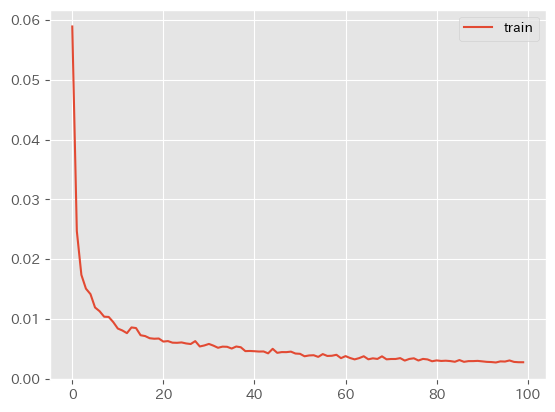

In [25]:
# 損失関数のグラフを表示
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            11200     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

### テストデータの作成

In [27]:
test_data = scaled_data[training_data_len - window_size:,:]

x_test = []
y_test = []
for i in range(window_size,len(test_data)-predict_size+1):
    x_test.append(test_data[i-window_size:i,:])
    y_test.append(test_data[i:i+predict_size,0:4])

x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
y_test = y_test.reshape(y_test.shape[0],-1)
print(y_test.shape)

(177, 60, 5)
(177, 20)


### 学習済みモデルによるテストデータの予測

In [28]:
#(始値、終値、高値、安値)
prediction = model.predict(x_test)
prediction
#prediction_low = prediction[:,1::2]
#prediction = scaler_low.inverse_transform(prediction)

6/6 [==============================] - 1s 10ms/step


array([[0.08243844, 0.08554345, 0.08665763, ..., 0.08725195, 0.08404561,
        0.11631296],
       [0.08150568, 0.08466953, 0.08575365, ..., 0.08663516, 0.08334258,
        0.11556906],
       [0.08238439, 0.08567887, 0.08668084, ..., 0.08782757, 0.08452087,
        0.11669399],
       ...,
       [0.01052989, 0.0124476 , 0.01399516, ..., 0.01808664, 0.01211628,
        0.0429109 ],
       [0.01164985, 0.01365434, 0.01512122, ..., 0.01971699, 0.01371473,
        0.04436892],
       [0.01317768, 0.0152794 , 0.01660526, ..., 0.02175392, 0.01578414,
        0.04626586]], dtype=float32)

In [29]:
# 始値、終値、高値、安値に変更
prediction_open = prediction[:,::4]
prediction_close = prediction[:,1::4]
prediction_high = prediction[:,2::4]
prediction_low = prediction[:,3::4]

# スケールの逆変換
prediction_open = scaler_open.inverse_transform(prediction_open)
prediction_high = scaler_high.inverse_transform(prediction_high)
prediction_low = scaler_low.inverse_transform(prediction_low)
prediction_close = scaler_close.inverse_transform(prediction_close)
prediction_close.shape


(177, 5)

 ## 予測結果

 - 終値、始値、高値、安値それぞれ5日間の予測結果の正解データとの比較を行い、MAPEによる評価を行う

### 終値について

In [30]:
train_plot = df.loc[500:len(train_data),['日時','調整後終値']]
predict = prediction_close

#正解データ
correct_day1 = df.loc[len(train_data):len(df)-5,['日時','調整後終値']]
correct_day2 = df.loc[len(train_data)+1:len(df)-4,['日時','調整後終値']]
correct_day3 = df.loc[len(train_data)+2:len(df)-3,['日時','調整後終値']]
correct_day4 = df.loc[len(train_data)+3:len(df)-2,['日時','調整後終値']]
correct_day5 = df.loc[len(train_data)+4:len(df)-1,['日時','調整後終値']]

#予測データ
predict_day1 = predict[:,0].reshape(-1,1)
predict_day2 = predict[:,1].reshape(-1,1)
predict_day3 = predict[:,2].reshape(-1,1)
predict_day4 = predict[:,3].reshape(-1,1)
predict_day5 = predict[:,4].reshape(-1,1)

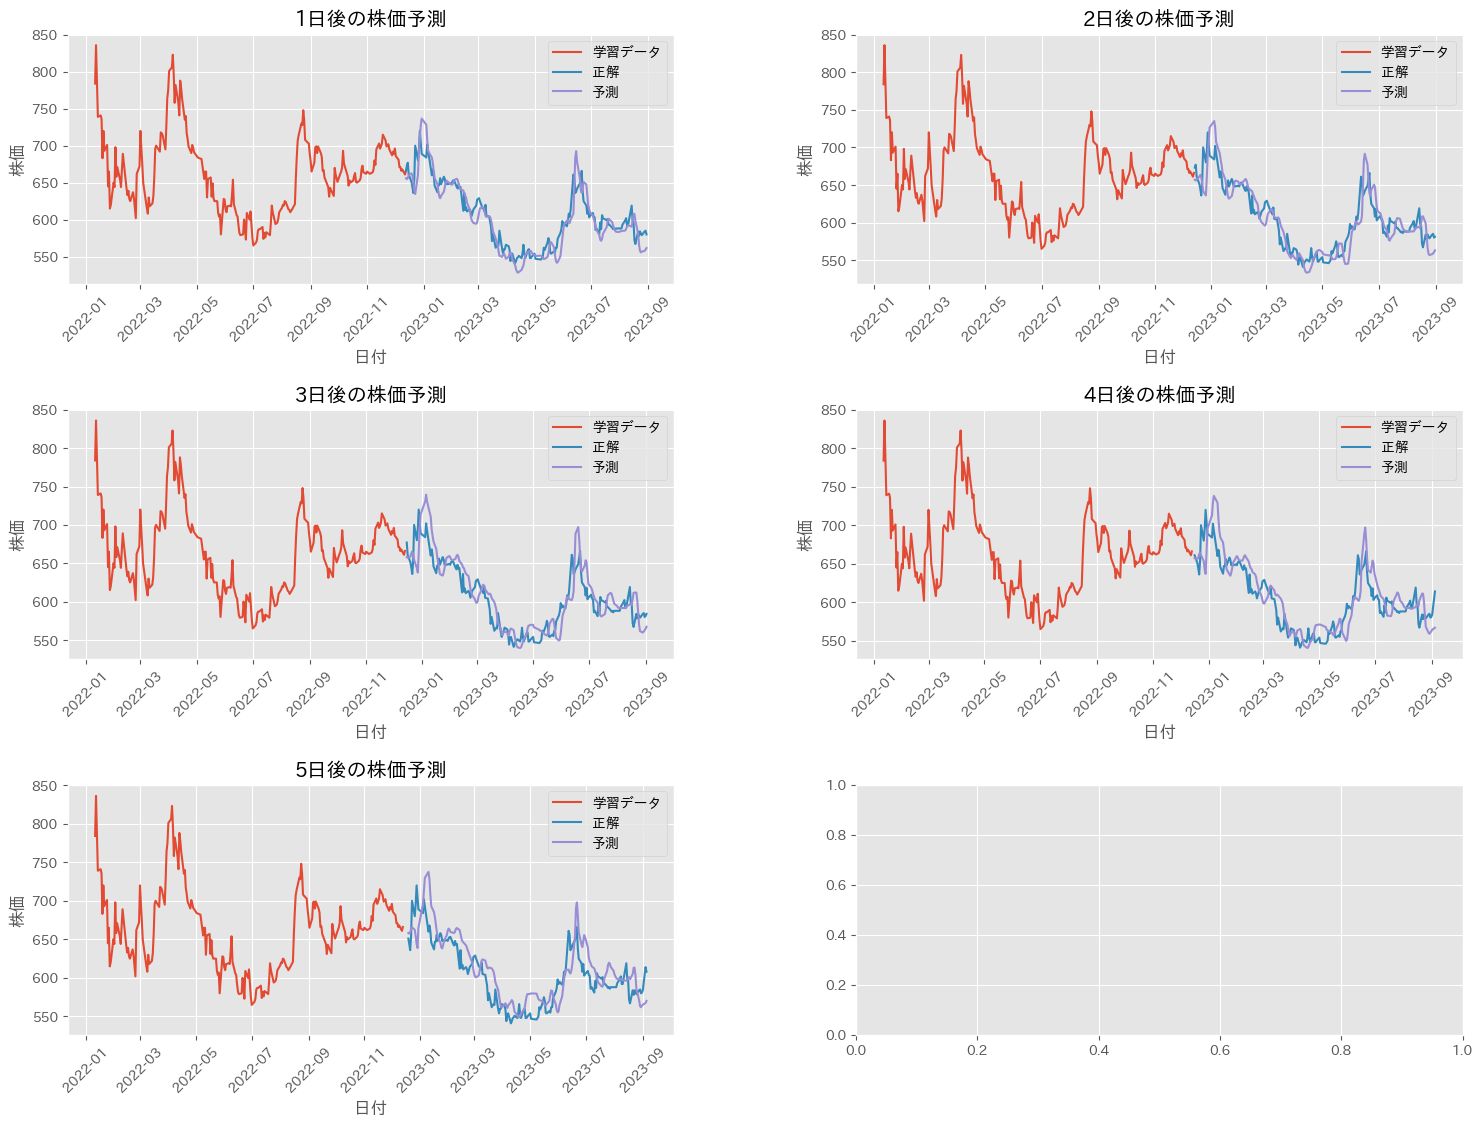

In [31]:
fig, axes = plt.subplots(3,2,figsize=(18,13))

axes[0,0].plot(train_plot['日時'],train_plot['調整後終値'])
axes[0,0].plot(correct_day1['日時'],correct_day1['調整後終値'])
axes[0,0].plot(correct_day1['日時'],predict_day1)
axes[0,0].set_title('1日後の株価予測')
axes[0,0].set_xlabel('日付')
axes[0,0].set_ylabel('株価')
axes[0,0].legend(['学習データ','正解','予測'])
axes[0,0].tick_params(axis='x', rotation=45)

axes[0,1].plot(train_plot['日時'],train_plot['調整後終値'])
axes[0,1].plot(correct_day2['日時'],correct_day2['調整後終値'])
axes[0,1].plot(correct_day2['日時'],predict_day2)
axes[0,1].set_title('2日後の株価予測')
axes[0,1].set_xlabel('日付')
axes[0,1].set_ylabel('株価')
axes[0,1].legend(['学習データ','正解','予測'])
axes[0,1].tick_params(axis='x', rotation=45)

axes[1,0].plot(train_plot['日時'],train_plot['調整後終値'])
axes[1,0].plot(correct_day3['日時'],correct_day3['調整後終値'])
axes[1,0].plot(correct_day3['日時'],predict_day3)
axes[1,0].set_title('3日後の株価予測')
axes[1,0].set_xlabel('日付')
axes[1,0].set_ylabel('株価')
axes[1,0].legend(['学習データ','正解','予測'])
axes[1,0].tick_params(axis='x', rotation=45)

axes[1,1].plot(train_plot['日時'],train_plot['調整後終値'])
axes[1,1].plot(correct_day4['日時'],correct_day4['調整後終値'])
axes[1,1].plot(correct_day4['日時'],predict_day4)
axes[1,1].set_title('4日後の株価予測')
axes[1,1].set_xlabel('日付')
axes[1,1].set_ylabel('株価')
axes[1,1].legend(['学習データ','正解','予測'])
axes[1,1].tick_params(axis='x', rotation=45)

axes[2,0].plot(train_plot['日時'],train_plot['調整後終値'])
axes[2,0].plot(correct_day5['日時'],correct_day5['調整後終値'])
axes[2,0].plot(correct_day5['日時'],predict_day5)
axes[2,0].set_title('5日後の株価予測')
axes[2,0].set_xlabel('日付')
axes[2,0].set_ylabel('株価')
axes[2,0].legend(['学習データ','正解','予測'])
axes[2,0].tick_params(axis='x', rotation=45)

plt.subplots_adjust(hspace=0.5, wspace=0.3)

#### 評価 : (MAPE)

In [32]:
def mape(actual, predicted):
    """
    Mean Absolute Percentage Error (MAPE)
    actual: list of actual values
    predicted: list of predicted values
    """
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [33]:
MAPE_day1 = mape(correct_day1['調整後終値'],predict_day1)
MAPE_day2 = mape(correct_day2['調整後終値'],predict_day2)
MAPE_day3 = mape(correct_day3['調整後終値'],predict_day3)
MAPE_day4 = mape(correct_day4['調整後終値'],predict_day4)
MAPE_day5 = mape(correct_day5['調整後終値'],predict_day5)

print(f"1日後のMAPE：{MAPE_day1}")
print(f"2日後のMAPE：{MAPE_day2}")
print(f"3日後のMAPE：{MAPE_day3}")
print(f"4日後のMAPE：{MAPE_day4}")
print(f"5日後のMAPE：{MAPE_day5}")


1日後のMAPE：8.108831269740715
2日後のMAPE：7.963497158914857
3日後のMAPE：7.895209379734602
4日後のMAPE：7.829674306671213
5日後のMAPE：7.743349742288933


### 始値について

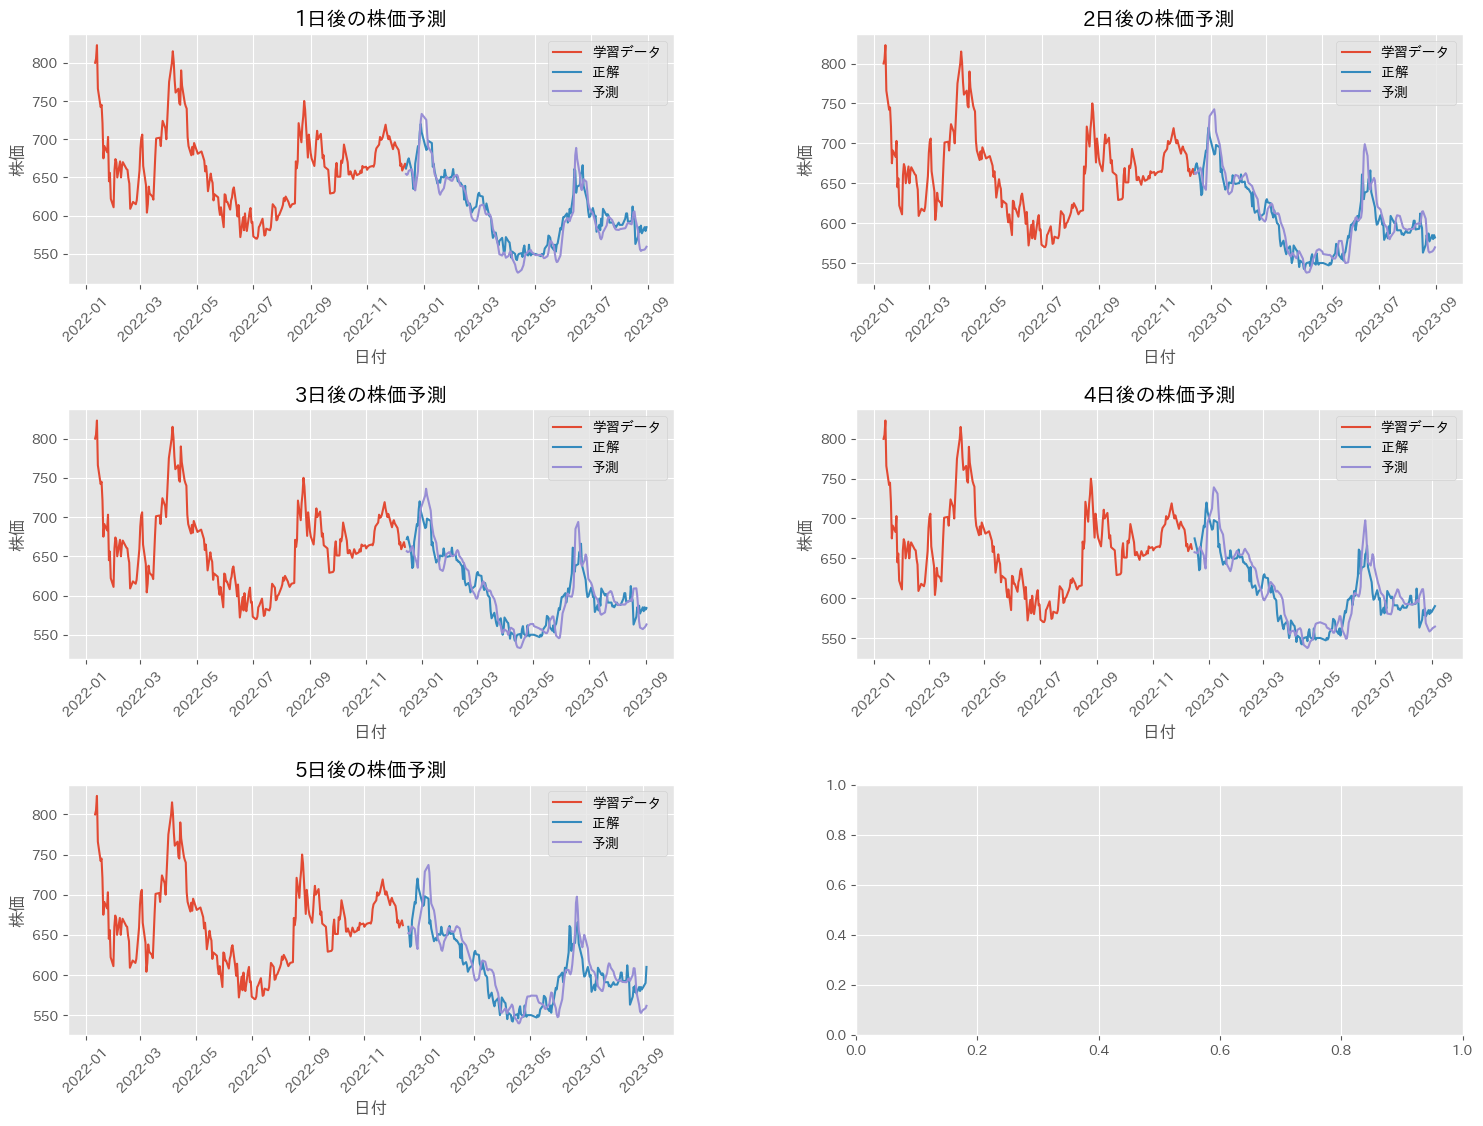

In [34]:
train_plot = df.loc[500:len(train_data),['日時','調整後始値']]
predict = prediction_open

#正解データ
correct_day1 = df.loc[len(train_data):len(df)-5,['日時','調整後始値']]
correct_day2 = df.loc[len(train_data)+1:len(df)-4,['日時','調整後始値']]
correct_day3 = df.loc[len(train_data)+2:len(df)-3,['日時','調整後始値']]
correct_day4 = df.loc[len(train_data)+3:len(df)-2,['日時','調整後始値']]
correct_day5 = df.loc[len(train_data)+4:len(df)-1,['日時','調整後始値']]

#予測データ
predict_day1 = predict[:,0].reshape(-1,1)
predict_day2 = predict[:,1].reshape(-1,1)
predict_day3 = predict[:,2].reshape(-1,1)
predict_day4 = predict[:,3].reshape(-1,1)
predict_day5 = predict[:,4].reshape(-1,1)

fig, axes = plt.subplots(3,2,figsize=(18,13))

axes[0,0].plot(train_plot['日時'],train_plot['調整後始値'])
axes[0,0].plot(correct_day1['日時'],correct_day1['調整後始値'])
axes[0,0].plot(correct_day1['日時'],predict_day1)
axes[0,0].set_title('1日後の株価予測')
axes[0,0].set_xlabel('日付')
axes[0,0].set_ylabel('株価')
axes[0,0].legend(['学習データ','正解','予測'])
axes[0,0].tick_params(axis='x', rotation=45)

axes[0,1].plot(train_plot['日時'],train_plot['調整後始値'])
axes[0,1].plot(correct_day2['日時'],correct_day2['調整後始値'])
axes[0,1].plot(correct_day2['日時'],predict_day2)
axes[0,1].set_title('2日後の株価予測')
axes[0,1].set_xlabel('日付')
axes[0,1].set_ylabel('株価')
axes[0,1].legend(['学習データ','正解','予測'])
axes[0,1].tick_params(axis='x', rotation=45)

axes[1,0].plot(train_plot['日時'],train_plot['調整後始値'])
axes[1,0].plot(correct_day3['日時'],correct_day3['調整後始値'])
axes[1,0].plot(correct_day3['日時'],predict_day3)
axes[1,0].set_title('3日後の株価予測')
axes[1,0].set_xlabel('日付')
axes[1,0].set_ylabel('株価')
axes[1,0].legend(['学習データ','正解','予測'])
axes[1,0].tick_params(axis='x', rotation=45)

axes[1,1].plot(train_plot['日時'],train_plot['調整後始値'])
axes[1,1].plot(correct_day4['日時'],correct_day4['調整後始値'])
axes[1,1].plot(correct_day4['日時'],predict_day4)
axes[1,1].set_title('4日後の株価予測')
axes[1,1].set_xlabel('日付')
axes[1,1].set_ylabel('株価')
axes[1,1].legend(['学習データ','正解','予測'])
axes[1,1].tick_params(axis='x', rotation=45)

axes[2,0].plot(train_plot['日時'],train_plot['調整後始値'])
axes[2,0].plot(correct_day5['日時'],correct_day5['調整後始値'])
axes[2,0].plot(correct_day5['日時'],predict_day5)
axes[2,0].set_title('5日後の株価予測')
axes[2,0].set_xlabel('日付')
axes[2,0].set_ylabel('株価')
axes[2,0].legend(['学習データ','正解','予測'])
axes[2,0].tick_params(axis='x', rotation=45)

plt.subplots_adjust(hspace=0.5, wspace=0.3)


In [35]:
MAPE_day1 = mape(correct_day1['調整後始値'],predict_day1)
MAPE_day2 = mape(correct_day2['調整後始値'],predict_day2)
MAPE_day3 = mape(correct_day3['調整後始値'],predict_day3)
MAPE_day4 = mape(correct_day4['調整後始値'],predict_day4)
MAPE_day5 = mape(correct_day5['調整後始値'],predict_day5)

print(f"1日後のMAPE：{MAPE_day1}")
print(f"2日後のMAPE：{MAPE_day2}")
print(f"3日後のMAPE：{MAPE_day3}")
print(f"4日後のMAPE：{MAPE_day4}")
print(f"5日後のMAPE：{MAPE_day5}")

1日後のMAPE：8.178965033953583
2日後のMAPE：8.102744946817591
3日後のMAPE：8.005753620747619
4日後のMAPE：7.981000117853091
5日後のMAPE：7.787966848885322


### 高値について

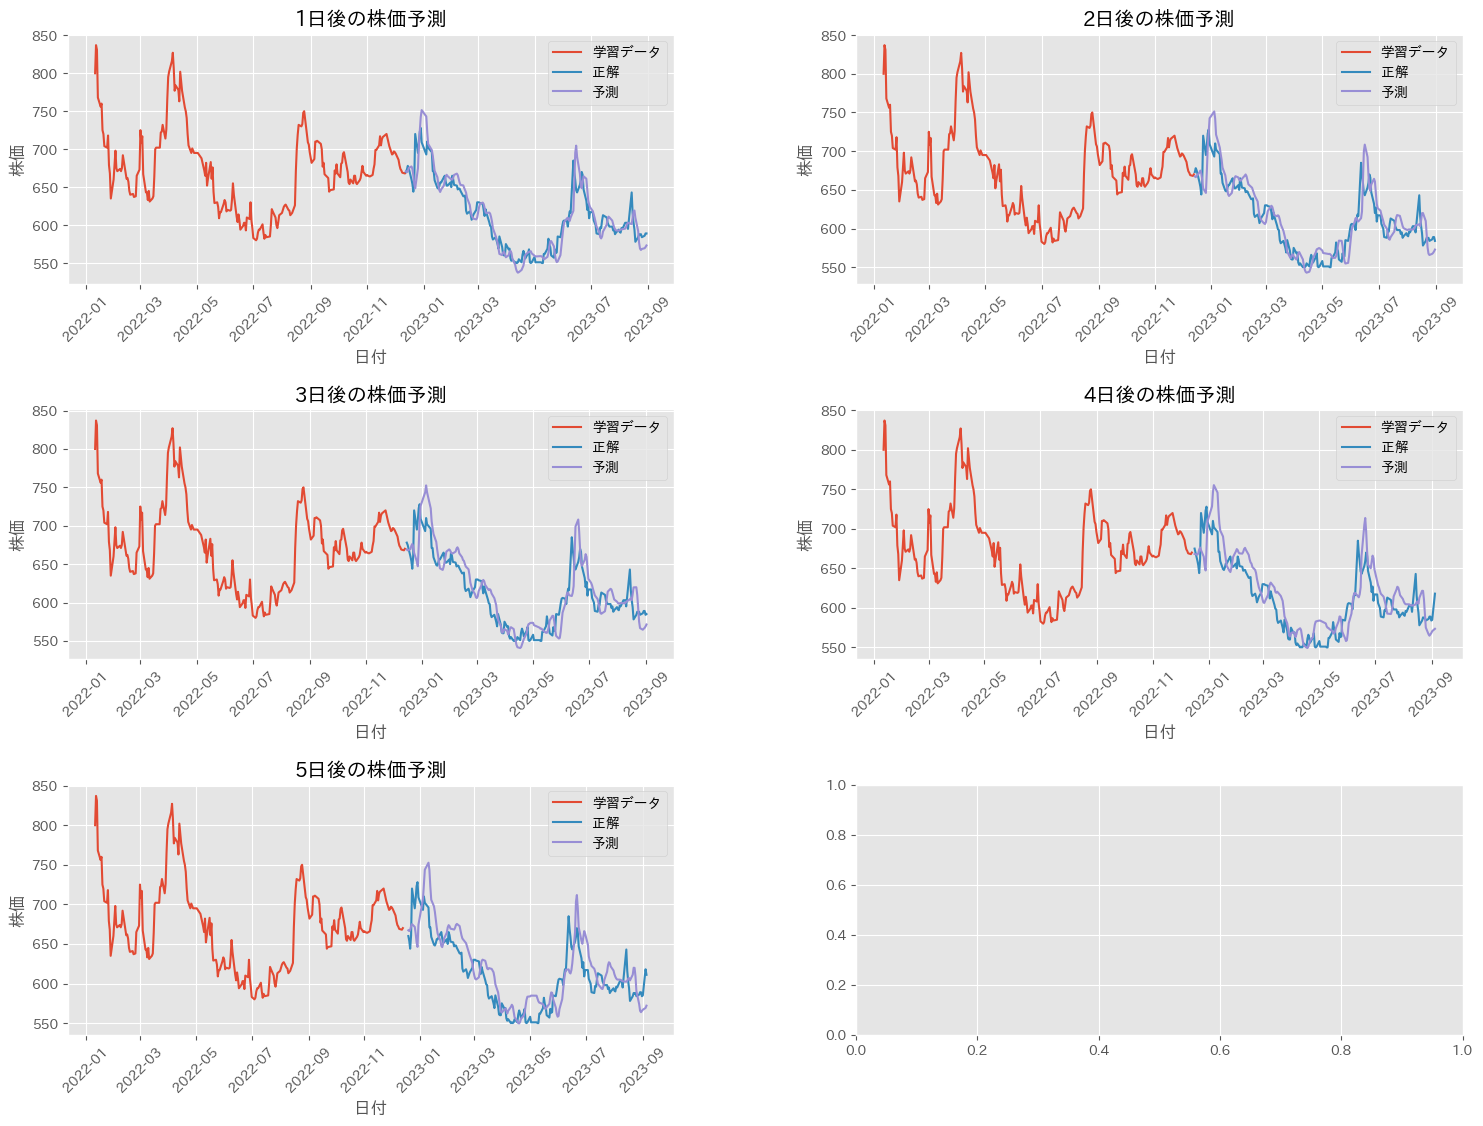

In [36]:
train_plot = df.loc[500:len(train_data),['日時','調整後高値']]
predict = prediction_high

#正解データ
correct_day1 = df.loc[len(train_data):len(df)-5,['日時','調整後高値']]
correct_day2 = df.loc[len(train_data)+1:len(df)-4,['日時','調整後高値']]
correct_day3 = df.loc[len(train_data)+2:len(df)-3,['日時','調整後高値']]
correct_day4 = df.loc[len(train_data)+3:len(df)-2,['日時','調整後高値']]
correct_day5 = df.loc[len(train_data)+4:len(df)-1,['日時','調整後高値']]

#予測データ
predict_day1 = predict[:,0].reshape(-1,1)
predict_day2 = predict[:,1].reshape(-1,1)
predict_day3 = predict[:,2].reshape(-1,1)
predict_day4 = predict[:,3].reshape(-1,1)
predict_day5 = predict[:,4].reshape(-1,1)

fig, axes = plt.subplots(3,2,figsize=(18,13))

axes[0,0].plot(train_plot['日時'],train_plot['調整後高値'])
axes[0,0].plot(correct_day1['日時'],correct_day1['調整後高値'])
axes[0,0].plot(correct_day1['日時'],predict_day1)
axes[0,0].set_title('1日後の株価予測')
axes[0,0].set_xlabel('日付')
axes[0,0].set_ylabel('株価')
axes[0,0].legend(['学習データ','正解','予測'])
axes[0,0].tick_params(axis='x', rotation=45)

axes[0,1].plot(train_plot['日時'],train_plot['調整後高値'])
axes[0,1].plot(correct_day2['日時'],correct_day2['調整後高値'])
axes[0,1].plot(correct_day2['日時'],predict_day2)
axes[0,1].set_title('2日後の株価予測')
axes[0,1].set_xlabel('日付')
axes[0,1].set_ylabel('株価')
axes[0,1].legend(['学習データ','正解','予測'])
axes[0,1].tick_params(axis='x', rotation=45)

axes[1,0].plot(train_plot['日時'],train_plot['調整後高値'])
axes[1,0].plot(correct_day3['日時'],correct_day3['調整後高値'])
axes[1,0].plot(correct_day3['日時'],predict_day3)
axes[1,0].set_title('3日後の株価予測')
axes[1,0].set_xlabel('日付')
axes[1,0].set_ylabel('株価')
axes[1,0].legend(['学習データ','正解','予測'])
axes[1,0].tick_params(axis='x', rotation=45)

axes[1,1].plot(train_plot['日時'],train_plot['調整後高値'])
axes[1,1].plot(correct_day4['日時'],correct_day4['調整後高値'])
axes[1,1].plot(correct_day4['日時'],predict_day4)
axes[1,1].set_title('4日後の株価予測')
axes[1,1].set_xlabel('日付')
axes[1,1].set_ylabel('株価')
axes[1,1].legend(['学習データ','正解','予測'])
axes[1,1].tick_params(axis='x', rotation=45)

axes[2,0].plot(train_plot['日時'],train_plot['調整後高値'])
axes[2,0].plot(correct_day5['日時'],correct_day5['調整後高値'])
axes[2,0].plot(correct_day5['日時'],predict_day5)
axes[2,0].set_title('5日後の株価予測')
axes[2,0].set_xlabel('日付')
axes[2,0].set_ylabel('株価')
axes[2,0].legend(['学習データ','正解','予測'])
axes[2,0].tick_params(axis='x', rotation=45)

plt.subplots_adjust(hspace=0.5, wspace=0.3)


In [37]:
MAPE_day1 = mape(correct_day1['調整後高値'],predict_day1)
MAPE_day2 = mape(correct_day2['調整後高値'],predict_day2)
MAPE_day3 = mape(correct_day3['調整後高値'],predict_day3)
MAPE_day4 = mape(correct_day4['調整後高値'],predict_day4)
MAPE_day5 = mape(correct_day5['調整後高値'],predict_day5)

print(f"1日後のMAPE：{MAPE_day1}")
print(f"2日後のMAPE：{MAPE_day2}")
print(f"3日後のMAPE：{MAPE_day3}")
print(f"4日後のMAPE：{MAPE_day4}")
print(f"5日後のMAPE：{MAPE_day5}")

1日後のMAPE：8.354809603397035
2日後のMAPE：8.170370973760937
3日後のMAPE：8.24669333987298
4日後のMAPE：8.170424952769778
5日後のMAPE：8.113981312275204


### 安値について

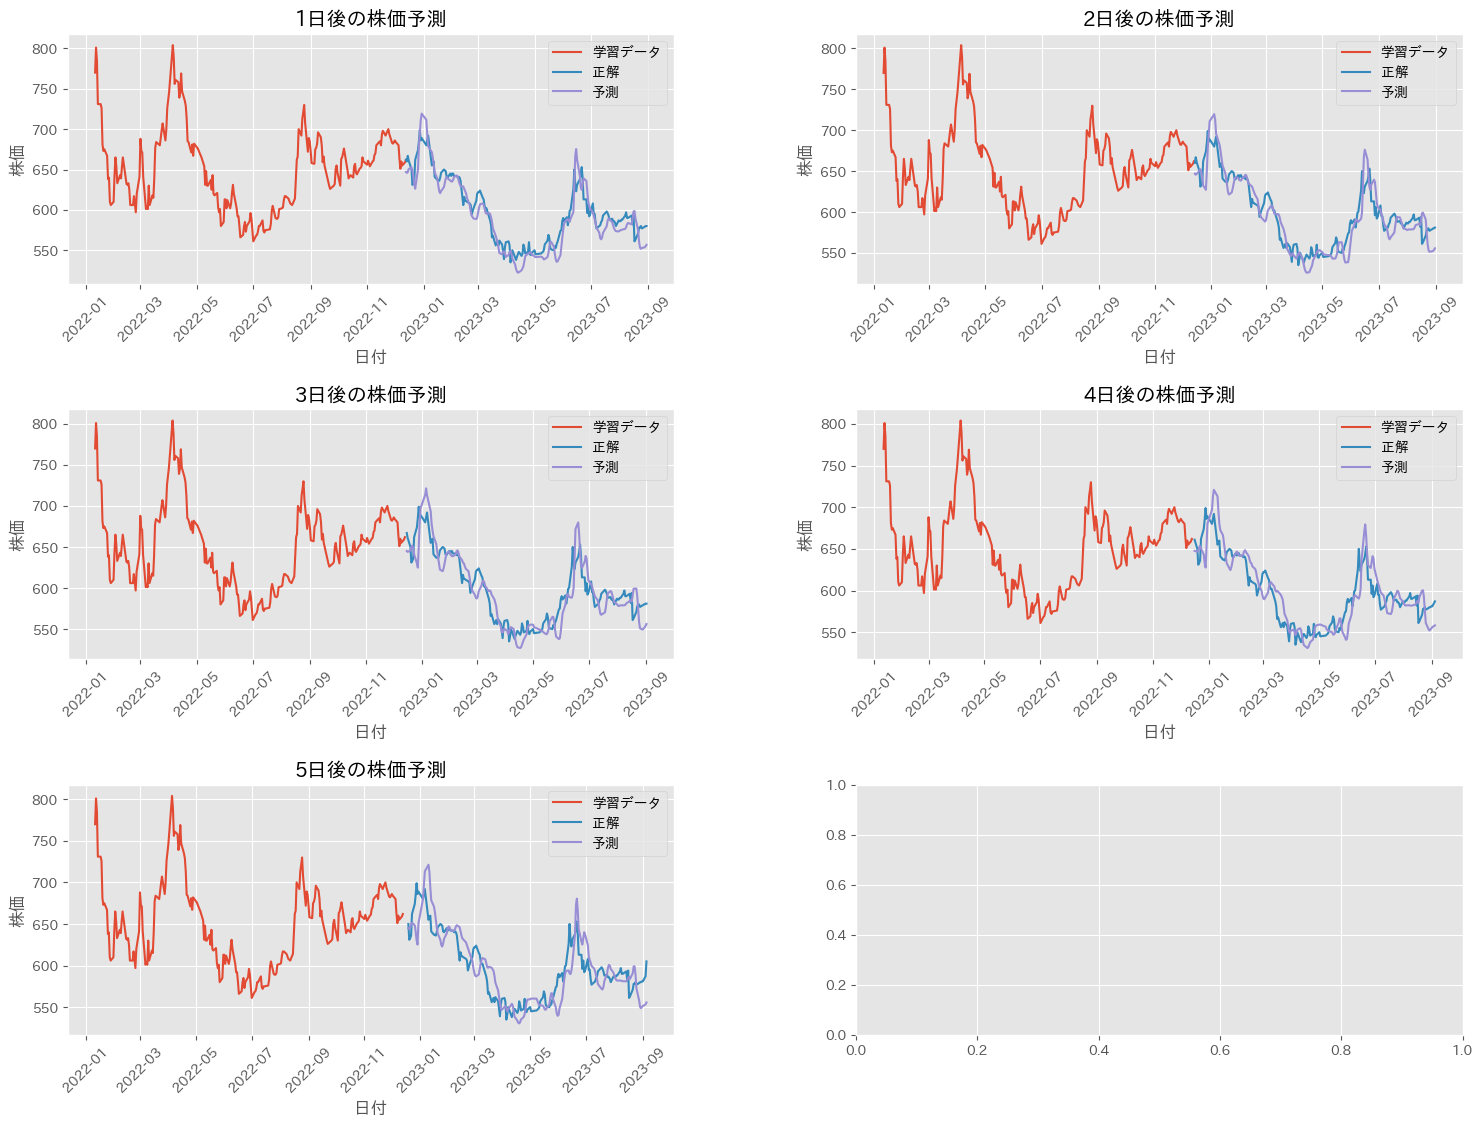

In [38]:
train_plot = df.loc[500:len(train_data),['日時','調整後安値']]
predict = prediction_low

#正解データ
correct_day1 = df.loc[len(train_data):len(df)-5,['日時','調整後安値']]
correct_day2 = df.loc[len(train_data)+1:len(df)-4,['日時','調整後安値']]
correct_day3 = df.loc[len(train_data)+2:len(df)-3,['日時','調整後安値']]
correct_day4 = df.loc[len(train_data)+3:len(df)-2,['日時','調整後安値']]
correct_day5 = df.loc[len(train_data)+4:len(df)-1,['日時','調整後安値']]

#予測データ
predict_day1 = predict[:,0].reshape(-1,1)
predict_day2 = predict[:,1].reshape(-1,1)
predict_day3 = predict[:,2].reshape(-1,1)
predict_day4 = predict[:,3].reshape(-1,1)
predict_day5 = predict[:,4].reshape(-1,1)

fig, axes = plt.subplots(3,2,figsize=(18,13))

axes[0,0].plot(train_plot['日時'],train_plot['調整後安値'])
axes[0,0].plot(correct_day1['日時'],correct_day1['調整後安値'])
axes[0,0].plot(correct_day1['日時'],predict_day1)
axes[0,0].set_title('1日後の株価予測')
axes[0,0].set_xlabel('日付')
axes[0,0].set_ylabel('株価')
axes[0,0].legend(['学習データ','正解','予測'])
axes[0,0].tick_params(axis='x', rotation=45)

axes[0,1].plot(train_plot['日時'],train_plot['調整後安値'])
axes[0,1].plot(correct_day2['日時'],correct_day2['調整後安値'])
axes[0,1].plot(correct_day2['日時'],predict_day2)
axes[0,1].set_title('2日後の株価予測')
axes[0,1].set_xlabel('日付')
axes[0,1].set_ylabel('株価')
axes[0,1].legend(['学習データ','正解','予測'])
axes[0,1].tick_params(axis='x', rotation=45)

axes[1,0].plot(train_plot['日時'],train_plot['調整後安値'])
axes[1,0].plot(correct_day3['日時'],correct_day3['調整後安値'])
axes[1,0].plot(correct_day3['日時'],predict_day3)
axes[1,0].set_title('3日後の株価予測')
axes[1,0].set_xlabel('日付')
axes[1,0].set_ylabel('株価')
axes[1,0].legend(['学習データ','正解','予測'])
axes[1,0].tick_params(axis='x', rotation=45)

axes[1,1].plot(train_plot['日時'],train_plot['調整後安値'])
axes[1,1].plot(correct_day4['日時'],correct_day4['調整後安値'])
axes[1,1].plot(correct_day4['日時'],predict_day4)
axes[1,1].set_title('4日後の株価予測')
axes[1,1].set_xlabel('日付')
axes[1,1].set_ylabel('株価')
axes[1,1].legend(['学習データ','正解','予測'])
axes[1,1].tick_params(axis='x', rotation=45)

axes[2,0].plot(train_plot['日時'],train_plot['調整後安値'])
axes[2,0].plot(correct_day5['日時'],correct_day5['調整後安値'])
axes[2,0].plot(correct_day5['日時'],predict_day5)
axes[2,0].set_title('5日後の株価予測')
axes[2,0].set_xlabel('日付')
axes[2,0].set_ylabel('株価')
axes[2,0].legend(['学習データ','正解','予測'])
axes[2,0].tick_params(axis='x', rotation=45)

plt.subplots_adjust(hspace=0.5, wspace=0.3)


In [39]:
MAPE_day1 = mape(correct_day1['調整後安値'],predict_day1)
MAPE_day2 = mape(correct_day2['調整後安値'],predict_day2)
MAPE_day3 = mape(correct_day3['調整後安値'],predict_day3)
MAPE_day4 = mape(correct_day4['調整後安値'],predict_day4)
MAPE_day5 = mape(correct_day5['調整後安値'],predict_day5)

print(f"1日後のMAPE：{MAPE_day1}")
print(f"2日後のMAPE：{MAPE_day2}")
print(f"3日後のMAPE：{MAPE_day3}")
print(f"4日後のMAPE：{MAPE_day4}")
print(f"5日後のMAPE：{MAPE_day5}")

1日後のMAPE：7.904628409347751
2日後のMAPE：7.781920153131994
3日後のMAPE：7.707556123842041
4日後のMAPE：7.635794466430762
5日後のMAPE：7.59963316965922


### 予測値と正解値の差（安値1日目）

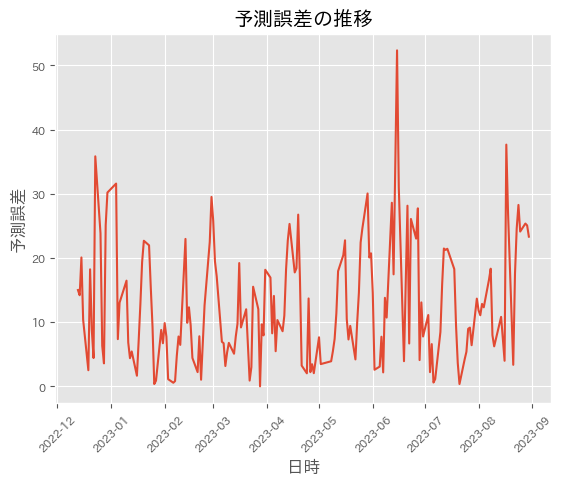

In [40]:
correct_array = np.array(correct_day1['調整後安値']).flatten()
predict_array = predict_day1.flatten()

# 演算を行う
diff = abs(correct_array - predict_array)
plt.plot(correct_day1['日時'],diff)

plt.xlabel('日時')
plt.ylabel('予測誤差')
plt.title('予測誤差の推移')

# 目盛りの設定
plt.xticks(rotation=45)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tick_params(axis='y', which='major', labelsize=8)

## 本番予測
- 実際に最新の60日間のデータを入力として株価（5日間）の予測を行う。

### 入力データ取得および学習済みモデルに代入

In [41]:
#過去60日間の最新データを取得
real_predict_data = scaled_data[-window_size:]
real_predict_data = np.array([real_predict_data])
real_predict_data.shape

(1, 60, 5)

In [42]:
predicted_stock_price = model.predict(real_predict_data)
predicted_stock_price

# 始値、終値、安値、高値に変更
predicted_stock_price_open = predicted_stock_price[:,::4]
predicted_stock_price_close = predicted_stock_price[:,1::4]
predicted_stock_price_high = predicted_stock_price[:,2::4]
predicted_stock_price_low = predicted_stock_price[:,3::4]

# スケールの逆変換
predicted_stock_price_open = scaler_open.inverse_transform(predicted_stock_price_open)
predicted_stock_price_high = scaler_high.inverse_transform(predicted_stock_price_high)
predicted_stock_price_low = scaler_low.inverse_transform(predicted_stock_price_low)
predicted_stock_price_close = scaler_close.inverse_transform(predicted_stock_price_close)

predicted_stock_price_open = predicted_stock_price_open.reshape(-1,1)
predicted_stock_price_high = predicted_stock_price_high.reshape(-1,1)
predicted_stock_price_low = predicted_stock_price_low.reshape(-1,1)
predicted_stock_price_close = predicted_stock_price_close.reshape(-1,1)

# predicted_stock_price = scaler_close.inverse_transform(predicted_stock_price)
# predicted_stock_price = predicted_stock_price.reshape(-1,1)
# predicted_stock_price

1/1 [==============================] - 0s 15ms/step


### 予測結果

In [43]:
## 日付生成
today = datetime.today()
cal = Japan()

# 5日後までの日付を取得
dates = []
for i in range(5):
    date = cal.add_working_days(today,i)
    dates.append(date)
    
dates = np.array(dates)
dates


array([datetime.date(2023, 9, 6), datetime.date(2023, 9, 7),
       datetime.date(2023, 9, 8), datetime.date(2023, 9, 11),
       datetime.date(2023, 9, 12)], dtype=object)

In [44]:
predicted_stock_price_data = np.concatenate((dates.reshape(-1, 1),predicted_stock_price_open,predicted_stock_price_close,predicted_stock_price_high,predicted_stock_price_low),axis=1)
predicted_stock_price_df = pd.DataFrame(predicted_stock_price_data,columns=['日時','始値','終値','高値','安値'])
predicted_stock_price_df = predicted_stock_price_df.set_index(pd.to_datetime(predicted_stock_price_df['日時']))
predicted_stock_price_df = predicted_stock_price_df.drop('日時', axis=1)
predicted_stock_price_df[['始値','終値','高値','安値']] = predicted_stock_price_df[['始値','終値','高値','安値']].astype(np.float64)
predicted_stock_price_df = predicted_stock_price_df.round({'始値':1, '終値':1,'高値':1, '安値':1})
predicted_stock_price_df

,始値,終値,高値,安値
日時,,,,
2023-09-06,584.9,587.7,598.6,579.3
2023-09-07,596.0,589.8,600.7,579.6
2023-09-08,589.8,594.9,600.0,581.8
2023-09-11,592.0,594.6,604.5,583.5
2023-09-12,592.3,598.6,602.9,582.4


### 終値の株価推移予測

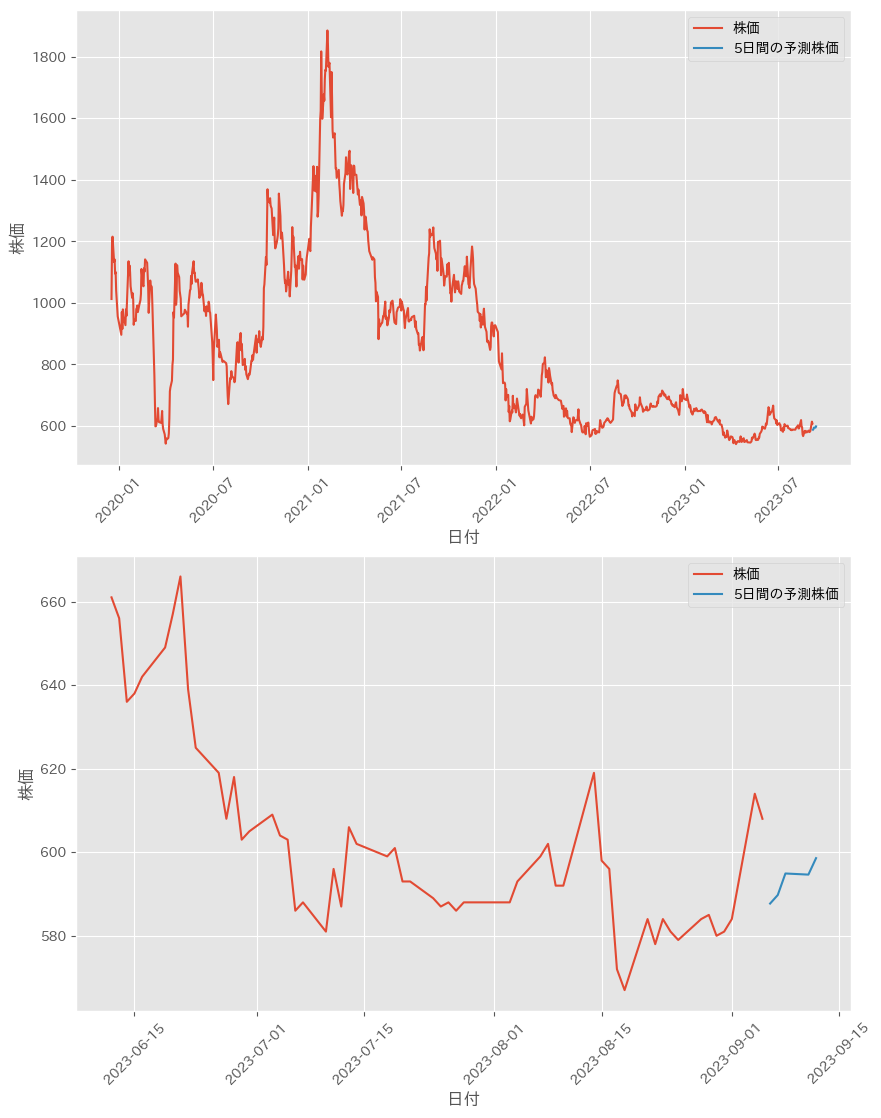

In [45]:
fig, axes = plt.subplots(2,1,figsize=(10,13))

axes[0].plot(df['日時'],df['調整後終値'])
axes[0].plot(dates,predicted_stock_price_close)
axes[0].set_xlabel('日付')
axes[0].set_ylabel('株価')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(['株価','5日間の予測株価'])

axes[1].plot(df.iloc[-window_size:]['日時'],df.iloc[-window_size:]['調整後終値'])
axes[1].plot(dates,predicted_stock_price_close)
axes[1].set_xlabel('日付')
axes[1].set_ylabel('株価')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(['株価','5日間の予測株価'])


### ローソク足による過去株価と5日間の予測

In [46]:
## 過去のローソク足と5日間の予測ローソク足
fig = go.Figure()

df_train = df.loc[850:,:]
df_train = df_train.set_index(pd.to_datetime(df_train['日時']))
# df_trainのローソク足チャートを追加
fig.add_trace(go.Candlestick(x=df_train.index,
                open=df_train['調整後始値'],
                high=df_train['調整後高値'],
                low=df_train['調整後安値'],
                close=df_train['調整後終値'], name='過去株価',
                increasing=dict(line=dict(width=0.5),fillcolor='rgba(16, 185, 129, 0.1)'),
                decreasing=dict(line=dict(width=0.5),fillcolor='rgba(239, 68, 68, 0.1)')))

# predicted_stock_price_dfのローソク足チャートを追加
fig.add_trace(go.Candlestick(x=predicted_stock_price_df.index,
                open=predicted_stock_price_df['始値'],
                high=predicted_stock_price_df['高値'],
                low=predicted_stock_price_df['安値'],
                close=predicted_stock_price_df['終値'], name='5日間の予測'))


fig.update_layout(xaxis_rangeslider_visible=False, title='過去株価と5日間の予測')
fig.update_xaxes(title_text='日時')
fig.update_yaxes(title_text='株価')

fig.show()

In [47]:

fig =go.Figure(go.Candlestick(x=predicted_stock_price_df.index,
                open=predicted_stock_price_df['始値'],
                high=predicted_stock_price_df['高値'],
                low=predicted_stock_price_df['安値'],
                close=predicted_stock_price_df['終値'], name='5日間の予測'))

fig.update_layout(xaxis_rangeslider_visible=False, title='5日間の予測')
fig.update_xaxes(title_text='日時')
fig.update_yaxes(title_text='株価')
fig.show()

- モデルの評価について<br>
  ・評価指標とてMAPEを用いて株価予測（始値、終値、高値、安値）の評価をそれぞれ行った結果、概ね７〜８．５％の誤差となった。
  ・

- 精度向上について<br>
  ・信用買残のデータを追加する（ただし一般的には信用買残データは出回ってなさそう）<br>
  ・モデルの改善（今回はLSTMの株価予測の論文を参考にしたものをそのまま使用したが、層数等のパラメータをパラメトリックに検証する必要がある）<br>
  ・日経系平均株価やマザーズ指数などの指標を追加する（連動性があることが知られている）<br>
  ・株価の変化率や移動平均など、特徴量の計算方法を変更する
 

- 日経平均やマザーズ指数を採用する際に高値、安値、始値、終値のいずれかもしくは全てを採用するか